## Data Acquisition Example


In [65]:
# import libraries
import os
import sys
import shutil
import json
import numpy as np
import foboslib.pynqctrl
from foboslib.fobosctrl import FOBOSCtrl
from foboslib.fobosTVGen import FobosTVGen
import foboslib.projmgr
import foboslib.nexys3dut
#######################################################
# Acquisition Configuration
acqConf = {}
# Connection to Control Board
acqConf['ip'] = '192.168.10.99'
acqConf['port'] = 9995
# File Names and Locations
acqConf['workspace'] = "fobosworkspace"     # Folder to store projects
acqConf['projectName'] = "aes"              # Name of this project. Files will be in workspace/projectName/
acqConf['keyFile'] = "key.txt"              # key used for encryption / decryption
acqConf['bitFile'] = "half_duplex_dut.bit"  # Bitstream for programming the DUT (target) 
acqConf['plainFile'] = "plaintext.txt"      # plaintext in hex
acqConf['dinFile'] = "dinFile.txt"          # test vectors in FOBOS format incl. plaintext and key
acqConf['cipherFile'] = "ciphertext.txt"    # observed ciphertext, result from applying test vectors
acqConf['traceFile']  = "powerTraces.npy"   # Name of file for recording power traces
# Cipher Specific Information
acqConf['blockSize'] = 16                     # size of a block of plaintext in bytes
acqConf['cipherSize'] =  16                   # size of a block of ciphertext in bytes
acqConf['keySize'] =  16                      # size of the key in bytes

In [66]:
#Acquistion configuration
acqConf['traceNum'] = 10             # number of traces to run [default: 10]
acqConf['DUTClk'] = 2                 # clock frequency of the DUT in MHz, [range: 1 - 100]
acqConf['samplingFreq'] =  20          # sampling frequency of the Oscilloscope in Msps [default: 50][range: 1 - 100]
acqConf['samplesPerTrace'] = 1000        # number of sample in one trace [range: 1 - 2^17]
acqConf['ADCGain'] = 50              # amplification of ADC input signal [default: 40][range: 0 - 60]

In [67]:
# Configure project directories
pm = foboslib.projmgr.ProjectManager()
pm.setWorkSpaceDir(acqConf['workspace'])
pm.setProjName(acqConf['projectName'])
projDir = pm.getProjDir()
# Generate test vectors
tvGen = FobosTVGen(traceNum=acqConf['traceNum'],
                   blockSize=acqConf['blockSize'],
                   keySize=acqConf['keySize'],
                   cipherSize=acqConf['cipherSize'],
                   dinFile= os.path.join(projDir, acqConf['dinFile']),
                   plaintextFile=os.path.join(projDir, acqConf['plainFile']),
                   keyFile=os.path.join(projDir, acqConf['keyFile'])
                   )
tvGen.generateTVs()

Generating 10 test vectors...
    KeyFile = fobosworkspace/aes/key.txt
    PlaintextFile = fobosworkspace/aes/plaintext.txt
    Block Size (bytes) = 16
    Ciphertext Size (bytes) = 16
    Key Size (bytes)= 16
Done.


In [69]:
# connect to hardware and lock it ######################################
ctrl = foboslib.pynqctrl.PYNQCtrl(acqConf['ip'], acqConf['port'])
# Apply config to ctrl board ###########################################
try:
    ctrl.setDUTClk(acqConf['DUTClk'])
    ctrl.setDUTInterface(FOBOSCtrl.INTERFACE_4BIT)
    ctrl.setOutLen(acqConf['cipherSize'])
    ctrl.setTriggerMode(FOBOSCtrl.TRG_FULL)
    # configure trace sampling #############################################
    ctrl.setSamplingFrequency(acqConf['samplingFreq'])
    ctrl.setADCGain(acqConf['ADCGain'])
    ctrl.setSamplesPerTrace(acqConf['samplesPerTrace'])
except Exception as e:
    print(e)
    ctrl.disconnect()
else:
    # program DUT ##########################################################
    #dut = foboslib.nexys3dut.Nexys3DUT()
    #bitFile = os.path.join(projDir, acqConf['bitFile'])
    #dut.setBitFile(bitFile)
    #dut.program()
    # prepare i/o files ####################################################
    tvFileName = os.path.join(projDir, acqConf['dinFile'])
    plainFileName = os.path.join(projDir, acqConf['plainFile'])
    tvFile = open(tvFileName, "r")
    captureDir = pm.getCaptureDir()
    cipherFileName = os.path.join(captureDir, acqConf['cipherFile'])
    cipherFile = open(cipherFileName, "w")
    traceFileName = os.path.join(captureDir, acqConf['traceFile'])
    traceFile = open(traceFileName, "a+b")
    shutil.copy(tvFileName, captureDir)
    shutil.copy(plainFileName, captureDir)
    # save config to a file
    configFile = open(os.path.join(captureDir, 'acquisitionConfig.json'), "w")
    configFile.write(json.dumps(acqConf, indent=4))
    #configFile.write(ctrl.config)
    #print(ctrl.config)
    configFile.close()
    # Get traces############################################################
    print('Processing test vectors ...')
    traceNum = 0
    while traceNum < acqConf['traceNum']:
        data = tvFile.readline()
        status, result, trace = ctrl.processData2(data, acqConf['cipherSize'])
        cipherFile.write(result + "\n")
        np.save(traceFile, trace)
        if traceNum % 100 == 0:
            sys.stdout.write('Progress:' + "{:.2f}".format(traceNum/acqConf['traceNum']*100) + '%\r')
            sys.stdout.flush()
        traceNum += 1
    print('Data acquisition complete.')
    ctrl.disconnect() # release and reset control board.
    traceFile.close()
    cipherFile.close()
    tvFile.close()

Waiting for current user to release hardware. Please wait ...
Acquired hardware lock
Successfully created new capture directory at fobosworkspace/aes/capture/attempt-12
Processing test vectors ...
Data acquisition complete.
Released hardware lock.


<Figure size 432x288 with 0 Axes>

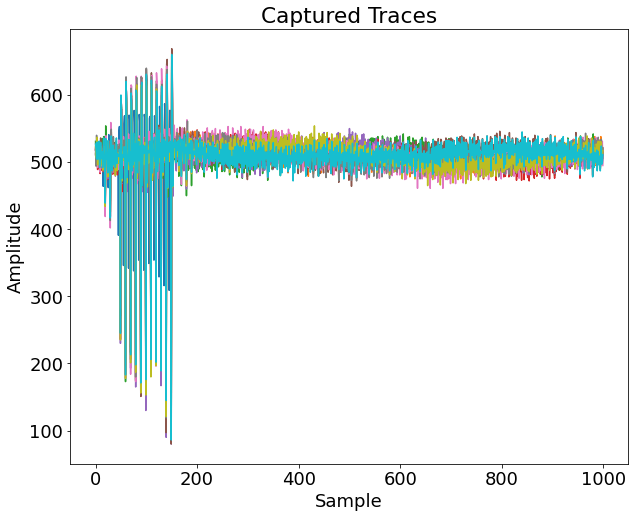

In [70]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.rcParams.update({'font.size': 18})
traceFile = open(traceFileName, "r+b")
maxtrace = 100
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Captured Traces')
for i in range(min(maxtrace, acqConf['traceNum'])):
    trace = np.load(traceFile)
    plt.plot(trace)

plt.savefig(os.path.join(captureDir, 'traces.png'),facecolor=fig.get_facecolor())
# plt.close()
traceFile.close()